In [1]:
import numpy as np
import pandas as pd
import torch
import os
from astropy.table import join, vstack, Table as AstroTable
import sagitta
from sagitta.data_tools import DataTools, SagittaDataset
from sagitta.model_code import Sagitta
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [2]:
df_hunt = pd.read_parquet('/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/Hunt2024/clusters.parquet')

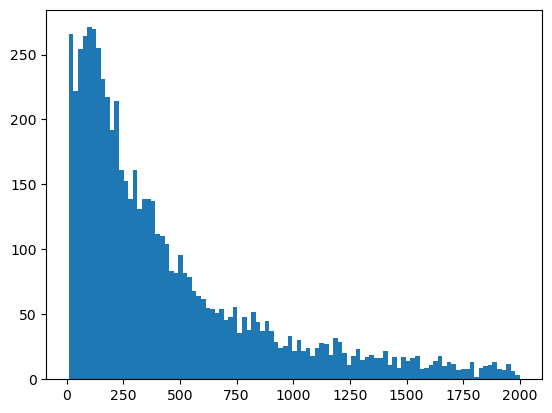

In [3]:
plt.hist(df_hunt.mass_all, bins=np.linspace(10, 2000, 100));

In [4]:
# Sample from truncated normal distribution
def sample_truncated_normal(mean, sd, low, upp):
    return truncnorm.rvs(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd
    )

In [5]:
sagitta_path, _ = os.path.split(os.path.abspath(sagitta.__file__))
state_dict_dir = os.path.join(sagitta_path, "model_state_dicts")

In [6]:
# Load data
# fpath_data = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/mock_cluster_500pc_3Myr_May2024.csv'
base_path = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/yso_study_simulation/'
fpath_data = base_path + 'simulated_data/sim_field_clusters_TrainTest_sagitta.csv'
df = pd.read_csv(fpath_data)
df['A_V_err'] = 0.1
df_test = df.loc[df.test_samples]

In [8]:
features_X = [
    'parallax_obs', 'A_V_obs',
    'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
    'j_obs', 'h_obs', 'k_obs', 
]

features_X_error = [
    'parallax_error', 'A_V_error',
    'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
    'j_error', 'h_error', 'k_error'
]

# Rename columns for Sagitta
sagitta2colnames = {
    'parallax': 'parallax_obs',
    'av': 'A_V_obs',
    'g': 'phot_g_mean_mag_obs',
    'bp': 'phot_bp_mean_mag_obs',
    'rp': 'phot_rp_mean_mag_obs',
    'j': 'j_obs',
    'h': 'h_obs',
    'k': 'k_obs',
    'eparallax': 'parallax_error',
    'eav': 'A_V_error',
    'eg': 'phot_g_mean_mag_error',
    'ebp': 'phot_bp_mean_mag_error',
    'erp': 'phot_rp_mean_mag_error',
    'ej': 'j_error',
    'eh': 'h_error',
    'ek': 'k_error'
}

In [9]:
data_frame = AstroTable.from_pandas(df_test)

# Predict PMS status with Sagitta

In [10]:
pms_dataset = SagittaDataset(
    frame=data_frame[features_X],
    data_format="PMSClassifier",
    column_names=sagitta2colnames
)
# Save in DataLoader
pms_dataloader = torch.utils.data.DataLoader(
    pms_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()//2,
    drop_last=False
)

In [11]:
# Load Sagitta model
age_model = Sagitta()
age_model.load_state_dict(
    torch.load(os.path.join(state_dict_dir, "pms_model.pt"), map_location=torch.device('cpu'))
)
age_model.to(torch.device('cpu'))
age_model.eval()

Sagitta(
  (feats): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,))
    (12): ReLU(inplace=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (cla

In [15]:
pms_predictions = []
for idx, section_input in enumerate(pms_dataloader):
    section_input = section_input.to(torch.device('cpu'))
    with torch.no_grad():
        print("\t{:.1f}% completed".format(idx/len(pms_dataloader)*100), end="\r")
        section_output = torch.sigmoid(age_model(section_input))
        pms_predictions.append(section_output)

# Get predictions
pms_predictions_single = torch.cat(pms_predictions).cpu().detach().numpy()

# age_predictions_single = DataTools.normalize_gaia(
#     column_vals=pms_predictions_single,
#     column_name="age",
#     back=True
# ).flatten()

In [14]:
pms_predictions_single

array([[  3.0299168 ],
       [ -2.9049923 ],
       [ -2.5277224 ],
       ...,
       [ -1.3043162 ],
       [-17.200613  ],
       [ -0.19090492]], dtype=float32)

In [16]:
df['pms_est_sagitta'] = 0 

In [17]:
df.loc[df.test_samples, 'pms_est_sagitta'] = pms_predictions_single

/var/folders/q4/vrqcgjz9259cd9jkzmpv3zth0000gn/T/ipykernel_46861/3145716294.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[9.5390749e-01 5.1907323e-02 7.3937446e-02 ... 2.1343951e-01 3.3874169e-08
 4.5241821e-01]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.test_samples, 'pms_est_sagitta'] = pms_predictions_single


In [21]:
df.loc[df.test_samples].to_csv(fpath_data.replace('.csv', '_pmsClf.csv'), index=False)

In [22]:
fpath_data.replace('.csv', '_pmsClf.csv')

'/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/yso_study_simulation/simulated_data/sim_field_clusters_TrainTest_sagitta_pmsClf.csv'

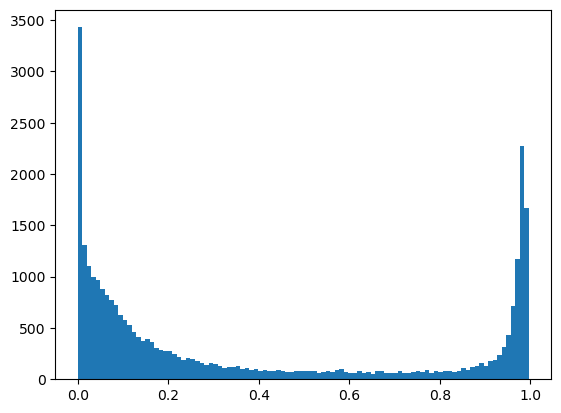

In [19]:
plt.hist(pms_predictions_single, bins=100);

# Predict ages with Sagitta

In [14]:
age_dataset = SagittaDataset(
    frame=data_frame[features_X],
    data_format="YoungStarAgeRegressor",
    column_names=sagitta2colnames
)
# Save in DataLoader
age_dataloader = torch.utils.data.DataLoader(
    age_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()//2,
    drop_last=False
)

In [15]:
# Load Sagitta model
age_model = Sagitta()
age_model.load_state_dict(
    torch.load(os.path.join(state_dict_dir, "age_model.pt"), map_location=torch.device('cpu'))
)
age_model.to(torch.device('cpu'))
age_model.eval()

Sagitta(
  (feats): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(2,))
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,))
    (12): ReLU(inplace=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0, inplace=False)
  (cla

In [16]:
age_predictions_single = []
for idx, section_input in enumerate(age_dataloader):
    section_input = section_input.to(torch.device('cpu'))
    with torch.no_grad():
        print("\t{:.1f}% completed".format(idx/len(age_dataloader)*100), end="\r")
        section_output = age_model(section_input)
        age_predictions_single.append(section_output)

# Get predictions
age_predictions_single = torch.cat(age_predictions_single).cpu().detach().numpy()
age_predictions_single = DataTools.normalize_gaia(
    column_vals=age_predictions_single,
    column_name="age",
    back=True
).flatten()

# Plot true vs predicted ages

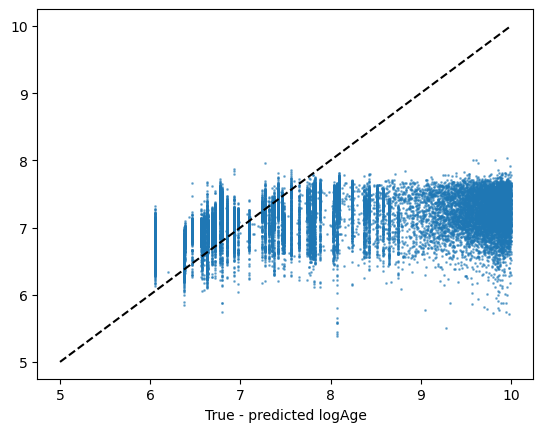

In [18]:
# plt.hist(df_test['logAge'].values - age_predictions_single, bins=np.linspace(-3, 5, 100))
plt.scatter(df_test['logAge'].values, age_predictions_single, s=1, alpha=0.5)
plt.plot([5, 10], [5, 10], 'k--')
plt.xlabel('True - predicted logAge')
# plt.ylabel('Predicted logAge')
plt.show()

# Estimate uncertainties

In [59]:
data_frame['source_id'] = np.arange(len(data_frame))

In [60]:
nb_mc_samples = 100

loop_frame = AstroTable()
loop_frame["source_id"] = data_frame["source_id"]
varied_frame = []
input_std_col_naming = {v: k for k, v in sagitta2colnames.items()}

for idx in range(nb_mc_samples):
    print("\t{:.1f}% completed".format(idx/nb_mc_samples*100), end="\r")
    # Sample photometry and parallax
    val_err_list = [
        [sagitta2colnames["g"], sagitta2colnames["eg"]],
        [sagitta2colnames["bp"], sagitta2colnames["ebp"]],
        [sagitta2colnames["rp"], sagitta2colnames["erp"]],
        [sagitta2colnames["j"], sagitta2colnames["ej"]],
        [sagitta2colnames["h"], sagitta2colnames["eh"]],
        [sagitta2colnames["k"], sagitta2colnames["ek"]],
        [sagitta2colnames["parallax"], sagitta2colnames["eparallax"]]
    ]
    for val, err in val_err_list:
        loop_frame[input_std_col_naming[val]] = data_frame[val] + np.random.normal(size=len(data_frame)) * data_frame[err]
    # Sample Av
    loop_frame["av"] = sample_truncated_normal(data_frame[sagitta2colnames["av"]].value, 0.1, 0, np.inf)
    # Sample parallax
    loop_frame["parallax"] = sample_truncated_normal(
        data_frame[sagitta2colnames["parallax"]].value, data_frame[sagitta2colnames["eparallax"]].value, 0, np.inf
    )
    # Add i'th samples to list
    varied_frame.append(loop_frame.copy())
    
varied_frame = vstack(varied_frame)

std_naming = {
    "parallax"  :   "parallax",
    "av"        :   "av",
    "g"         :   "g",
    "bp"        :   "bp",
    "rp"        :   "rp",
    "j"         :   "j",
    "h"         :   "h",
    "k"         :   "k"
}

In [61]:
df_varied = varied_frame.to_pandas()

In [62]:
age_uncertainty_dataset = SagittaDataset(
    frame=varied_frame,
    data_format="YoungStarAgeRegressor",
    column_names=std_naming
)

In [63]:
age_uncertainty_dataloader = torch.utils.data.DataLoader(
    age_uncertainty_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=os.cpu_count()//2,
    drop_last=False
)

In [64]:
age_predictions = []
for idx, section_input in enumerate(age_uncertainty_dataloader):
    section_input = section_input.to(torch.device('cpu'))
    with torch.no_grad():
        print("\t{:.1f}% completed".format(idx/len(age_uncertainty_dataloader)*100),
                end="\r")
        section_output = age_model(section_input)
        age_predictions.append(section_output)

age_predictions = torch.cat(age_predictions).cpu().detach().numpy()
varied_frame["age"] = DataTools.normalize_gaia(
    column_vals=age_predictions,
    column_name="age",
    back=True
).flatten()

In [65]:
print("\tAggregating the age uncertainties")
varied_frame = varied_frame[["source_id", "age"]].group_by("source_id")

age_stats_frame=AstroTable()
age_stats_frame["source_id"]  = varied_frame['source_id'].groups.aggregate(np.min)
age_stats_frame["age_mean_sagitta"]   = varied_frame['age'].groups.aggregate(np.mean)
age_stats_frame["age_median_sagitta"] = varied_frame['age'].groups.aggregate(np.median)
age_stats_frame["age_std_sagitta"]    = varied_frame['age'].groups.aggregate(np.std)
age_stats_frame["age_var_sagitta"]    = varied_frame['age'].groups.aggregate(np.var)
age_stats_frame["age_min_sagitta"]    = varied_frame['age'].groups.aggregate(np.min)
age_stats_frame["age_max_sagitta"]    = varied_frame['age'].groups.aggregate(np.max)

data_frame_final = join(data_frame, age_stats_frame, keys="source_id", join_type='inner')

	Aggregating the age uncertainties


In [66]:
df_final = data_frame_final.to_pandas()
df_final['age_est_sagitta'] = age_predictions_single

In [67]:
cols2match = ['age_est_sagitta', 'age_mean_sagitta', 'age_median_sagitta', 'age_std_sagitta', 'age_min_sagitta', 'age_max_sagitta']

# df.loc[df.id.isin(df_final.id), cols2match] = df_final[cols2match].values
df_combined = df.merge(df_final[['id'] + cols2match], on='id', how='left')

In [69]:
df_combined.to_csv(fpath_data.replace('.csv', '_sagitta.csv'), index=False)

In [70]:
fpath_data.replace('.csv', '_sagitta.csv')

'/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/edr3_mock_field_UNSEEN_clusters_TEST_sagitta_sagitta.csv'

(5.5, 8.0)

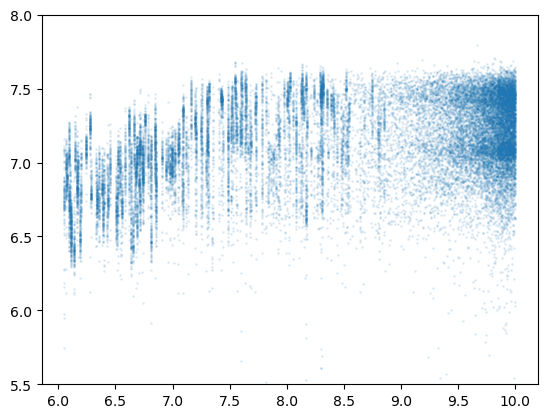

In [24]:
plt.scatter(
    df_combined.loc[df_combined.id>-1, 'logAge'], df_combined.loc[df_combined.id>-1, 'age_mean_sagitta'], 
    # bins=100
    s=1, alpha=0.1
)
plt.ylim(5.5, 8)

In [36]:
plt.scatter(df_combined.age_median, df_combined.age_std, s=1, alpha=0.1);

AttributeError: 'DataFrame' object has no attribute 'age_median'

In [ ]:
df_final.age_median.values, df_final.age_std.values

In [92]:
np.save('age_sagitta_median.npy', df_final.age_median.values)
np.save('age_sagitta_std.npy', df_final.age_std.values)

In [93]:
np.save('age_sagitta_std.npy', df_final.age_std.values)